# In case, the file import data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks
# !ls

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# Install libraries
!pip install mne
!pip install pyriemann
!pip install MOABB
!pip install  scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# References
- EEGANet: Removal of Ocular Artifact from the EEG Signal Using Generative Adversarial Networks
    - https://ieeexplore.ieee.org/document/9627782
    - https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/SRGAN
    - https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations/srgan
- Datasets
    - http://moabb.neurotechx.com/docs/generated/moabb.datasets.BNCI2014004.html#moabb.datasets.BNCI2014004
- Notes
    - 

## Import libraries and read files

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import mne
from mne import find_events, Epochs, pick_types, read_evokeds
from mne.preprocessing import ICA
from sklearn.preprocessing import MinMaxScaler
import pywt
import scipy
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from sklearn.neighbors import KDTree

import seaborn as sns

import os
import re

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
sfreq_after_epoch = 250
EOG_ref = "Regression"
ECG_ref = None

In [ ]:
def scaling_eeg(inputs, max_af, min_af):
    """
    Scaling eeg with the relative value accord multiple channels
    Think about the amplitude between the maximum values of 
    eye blink at Fp1 and normal eeg signal at Oz

    max_af = maximum value in inputs after normalize
    min_af = minimum value in inputs after normalize
    max_bf = maximum value in inputs before normalize
    min_bf = minimum value in inputs before normalize
    """ 
    max_bf=np.max(inputs)
    min_bf=np.min(inputs) 
    scaled_inputs = ((max_af - min_af) * (inputs - min_bf) / (max_bf - min_bf)) + min_af
    return scaled_inputs

In [ ]:
def Regression_on_epochs(epochs):
    # do regression
    _, betas = mne.preprocessing.regress_artifact(epochs.copy().subtract_evoked())
    # Then use those coefficients to remove the EOG signal from the original data
    epochs_clean, _ = mne.preprocessing.regress_artifact(epochs, betas=betas)
    return epochs_clean

In [ ]:
def artifact_removal(raw, EOG_ref, ECG_ref):
    """
    Calling a function of artifact removal technique according to 
    EOG_ref and ECG_ref parameters

    EOG_ref has 4 options
    1) None
    2) 'wICA_without_ref'
    3) 'wICA_with_ref'
    4) 'SRGAN'

    ECG_ref has 3 options
    1) None
    2) ICA_with_ref
    3) wICA_with_ref
    """
    input_raw = raw.copy()
    sfreq_after_epoch = 200 # Resample or not

    if EOG_ref == None and ECG_ref == None:
        output_raw = input_raw

    elif EOG_ref == 'wICA_without_ref' and ECG_ref == None:
        output_raw = wICA_on_raw_N170(raw, EOG_ref=False, ECG_ref=False)

    elif EOG_ref == 'wICA_with_ref' and ECG_ref == None:
        output_raw = wICA_on_raw_N170(raw, EOG_ref=True, ECG_ref=False)

    elif EOG_ref == None and ECG_ref == 'ICA_with_ref':
        output_raw = ICA_on_raw_N170(raw, ECG_ref=True)

    elif EOG_ref == 'wICA_without_ref' and ECG_ref == 'ICA_with_ref':
        output_raw = wICA_on_raw_N170(raw, EOG_ref=False, ECG_ref=False)

    elif EOG_ref == 'wICA_with_ref' and ECG_ref == 'ICA_with_ref':
        output_raw = wICA_on_raw_N170(raw, EOG_ref=True, ECG_ref=False)

    elif EOG_ref == 'wICA_without_ref' and ECG_ref == 'wICA_with_ref':
        output_raw = wICA_on_raw_N170(raw, EOG_ref=False, ECG_ref=False)

    elif EOG_ref == 'wICA_with_ref' and ECG_ref == 'wICA_with_ref':
        output_raw = wICA_on_raw_N170(raw, EOG_ref=True, ECG_ref=False)

    elif EOG_ref == 'Regression' and ECG_ref == None:
        output_raw = Regression_on_epochs(raw)

    return output_raw

## Raw

In [ ]:
ARTIFACT_SUB_FOLDER = f"raw_{sfreq_after_epoch}Hz-03EEGchs-{EOG_ref}-{ECG_ref}"

print(f"Folder name is {ARTIFACT_SUB_FOLDER}")

Folder name is raw_250Hz-03EEGchs-Regression-None


In [ ]:
import warnings

import matplotlib.pyplot as plt
import mne
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import BNCI2014004, Shin2017A
from moabb.evaluations import WithinSessionEvaluation, CrossSubjectEvaluation
from moabb.paradigms import LeftRightImagery


moabb.set_log_level("info")
mne.set_log_level("CRITICAL")
warnings.filterwarnings("ignore")

In [ ]:
list_subjects = list(np.arange(1,21))
selected_dataset = Shin2017A(accept=True)
event_id = selected_dataset.event_id
print(event_id)
dataset = selected_dataset.get_data(subjects=list_subjects)
print(dataset)

{'left_hand': 1, 'right_hand': 2}
{1: {'session_0': {'run_0': <RawArray | 33 x 120436 (602.2 s), ~30.4 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 119236 (596.2 s), ~30.1 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120851 (604.2 s), ~30.5 MB, data loaded>}}, 2: {'session_0': {'run_0': <RawArray | 33 x 120040 (600.2 s), ~30.3 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120624 (603.1 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120054 (600.3 s), ~30.3 MB, data loaded>}}, 3: {'session_0': {'run_0': <RawArray | 33 x 119446 (597.2 s), ~30.1 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120466 (602.3 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120244 (601.2 s), ~30.3 MB, data loaded>}}, 4: {'session_0': {'run_0': <RawArray | 33 x 119071 (595.4 s), ~30.0 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120465 (602.3 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray 

In [ ]:
print(selected_dataset.paradigm)
print(dataset)
print(dataset[1])

imagery
{1: {'session_0': {'run_0': <RawArray | 33 x 120436 (602.2 s), ~30.4 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 119236 (596.2 s), ~30.1 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120851 (604.2 s), ~30.5 MB, data loaded>}}, 2: {'session_0': {'run_0': <RawArray | 33 x 120040 (600.2 s), ~30.3 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120624 (603.1 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120054 (600.3 s), ~30.3 MB, data loaded>}}, 3: {'session_0': {'run_0': <RawArray | 33 x 119446 (597.2 s), ~30.1 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120466 (602.3 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 120244 (601.2 s), ~30.3 MB, data loaded>}}, 4: {'session_0': {'run_0': <RawArray | 33 x 119071 (595.4 s), ~30.0 MB, data loaded>}, 'session_2': {'run_0': <RawArray | 33 x 120465 (602.3 s), ~30.4 MB, data loaded>}, 'session_4': {'run_0': <RawArray | 33 x 119672 (598.4 s), ~

In [ ]:
test_raw = dataset[1]['session_0']['run_0'].copy()
print(test_raw.ch_names)
# events = mne.find_events(dataset[1]['session_0']['run_0'], stim_channel='stim')
events = mne.find_events(dataset[1]['session_0']['run_0'], stim_channel='Stim')
print(events.shape)

['F7', 'AFF5h', 'F3', 'AFp1', 'AFp2', 'AFF6h', 'F4', 'F8', 'AFF1h', 'AFF2h', 'Cz', 'Pz', 'FCC5h', 'FCC3h', 'CCP5h', 'CCP3h', 'T7', 'P7', 'P3', 'PPO1h', 'POO1', 'POO2', 'PPO2h', 'P4', 'FCC4h', 'FCC6h', 'CCP4h', 'CCP6h', 'P8', 'T8', 'VEOG', 'HEOG', 'Stim']
(20, 3)


### Extract contaminated eeg

In [ ]:
# #  BNCI2014004
# sfreq_after_epoch = int(test_raw.info['sfreq'])
# n_event_ids = 120 # The least #epochs per run
# selected_eeg_chs = test_raw.copy().pick_types(eeg=True, 
#                                        eog=False, 
#                                        ecg=False,
#                                        stim=False).ch_names
# # #samples in imagery period             
# selected_data_len = 1000                         

# Shin2017A
sfreq_after_epoch = int(test_raw.info['sfreq'])
n_event_ids = 20 # The least #epochs per run
selected_eeg_chs = test_raw.copy().pick_types(eeg=True, 
                                       eog=False, 
                                       ecg=False,
                                       stim=False).ch_names
# #samples in imagery period
time_per_task = 10
selected_data_len =  int(time_per_task * sfreq_after_epoch)

In [ ]:
test_raw.ch_names

['F7',
 'AFF5h',
 'F3',
 'AFp1',
 'AFp2',
 'AFF6h',
 'F4',
 'F8',
 'AFF1h',
 'AFF2h',
 'Cz',
 'Pz',
 'FCC5h',
 'FCC3h',
 'CCP5h',
 'CCP3h',
 'T7',
 'P7',
 'P3',
 'PPO1h',
 'POO1',
 'POO2',
 'PPO2h',
 'P4',
 'FCC4h',
 'FCC6h',
 'CCP4h',
 'CCP6h',
 'P8',
 'T8',
 'VEOG',
 'HEOG',
 'Stim']

In [ ]:
dataset[1]['session_0']['run_0']

<RawArray | 33 x 120436 (602.2 s), ~30.4 MB, data loaded>

In [ ]:
dataset[1]['session_0']['run_0'].get_data()

array([[ 8.06664247e-05,  8.65428387e-05,  8.04263314e-05, ...,
         2.69123945e-05,  2.13138022e-05,  3.48130797e-05],
       [ 6.41419887e-05,  6.96249141e-05,  6.49873439e-05, ...,
         8.22914520e-06,  3.48639683e-06,  1.53355087e-05],
       [ 5.96760476e-05,  5.54916712e-05,  4.56928075e-05, ...,
        -1.79970854e-05, -3.09610115e-05, -1.00266992e-05],
       ...,
       [-3.31149074e-04, -2.19437233e-04,  1.63019967e-05, ...,
        -1.21015303e-04,  1.35622957e-04,  6.23016323e-05],
       [ 7.56483153e-05,  7.70343574e-05,  6.82602603e-05, ...,
        -5.78586316e-05, -5.68241092e-05, -4.88676524e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
# Extract imaginary period (4 seconds)
EOG_ref = None
ECG_ref = None

train_cont_eeg = [] 
eval_cont_eeg =  []

train_cont_events = []
eval_cont_events = []

for subID in range(1,21):
    # for sessionID in ['session_0', 'session_1', 'session_2', 'session_3', 'session_4']:
    for sessionID in ['session_0', 'session_2', 'session_4']:

        for runID in ['run_0']:

            selected_raw = dataset[subID][sessionID][runID].copy()
            raw = selected_raw.copy()
            # Change unit from Volt to Micro Volt
            raw._data[:len(selected_eeg_chs), :] = raw._data.copy()[:len(selected_eeg_chs), :] * 1e6
            
            # Notch filter and Bandpass (BCI IV 2b is already applied)
            # Remove power line
            half_sfreq = int(raw.info['sfreq'] / 2)
            raw.notch_filter(freqs=np.arange(50,half_sfreq,50))
            raw.filter(1,50,n_jobs=2,fir_design='firwin') # Shin2017A

            # # 2d Min-Max scaling (-1,1)
            # scaled_eeg = scaling_eeg(inputs=raw._data[:len(selected_eeg_chs), :], max_af=1, min_af=-1)
            # raw._data[:len(selected_eeg_chs), :] = scaled_eeg

            # Apply Artifact removal technique on RAW
            # raw = artifact_removal(raw, EOG_ref=EOG_ref, ECG_ref=ECG_ref)

            # Drop bad channels 
            # Visual checking on evoked and some channels went bad after applying artifact removal techniques

            ch_names = raw.ch_names
            # events = mne.find_events(raw, stim_channel='stim')
            events = mne.find_events(raw, stim_channel='Stim')
            picks = mne.pick_types(raw.info,meg=False,eeg=True,stim=True,eog=True,ecg=False,misc=False)

            # Check
            print(raw._data[:3,:])
            print('='*100)

            # Shin2017A
            # Should subtract with [-5,-2] and then keep only [0,10]
            epochs = mne.Epochs(raw, events, event_id, tmin=-5, tmax=10.0, picks=picks,
                                            baseline=(-5,-2), reject=None, preload=True, 
                                            verbose=False)
            epochs.crop(tmin=0,tmax=10)

            # Apply Artifact removal technique on Epochs
            epochs = artifact_removal(epochs, EOG_ref=EOG_ref, ECG_ref=ECG_ref)
            
            # # Save data
            # epochs.save(fname=f'Datasets/BCI_IV_2b-preprocessed/{ARTIFACT_SUB_FOLDER}/sub-{subID:02}-{sessionID}-{runID}-eeg-epo.fif',
            #             split_size='2GB',
            #             overwrite=True,
            #             verbose=False)

            # # get numpy data 
            epochs.pick_types(eeg=True)
            epochs.pick_channels(ch_names=selected_eeg_chs)
            np_data = epochs.get_data()[:n_event_ids,:,:selected_data_len] # Shin2017A

            # Extract training data
            # if sessionID in ['session_0', 'session_1', 'session_2']: 
            if sessionID in ['session_0', 'session_2']:  # Shin2017A
                train_cont_eeg.append(np_data)
                train_cont_events.append(epochs.events[:n_event_ids])
            # Extract evaluating data
            else:
                eval_cont_eeg.append(np_data)
                eval_cont_events.append(epochs.events[:n_event_ids])

    #         break
    #     break
    # break
    
# List to Numpy
train_cont_eeg = np.array(train_cont_eeg)
eval_cont_eeg = np.array(eval_cont_eeg)

# Combined epochs
train_cont_eeg = train_cont_eeg.reshape(-1, len(selected_eeg_chs), selected_data_len)
eval_cont_eeg = eval_cont_eeg.reshape(-1, len(selected_eeg_chs), selected_data_len)

# Reshape list of events
# (Number of events, 3 datas)
# 3 datas = (Timestamp, Offset, Event)
train_cont_events = np.array(train_cont_events).reshape(-1,3)
eval_cont_events = np.array(eval_cont_events).reshape(-1,3)

# Extract Info for Numpy to EpochArray
eval_cont_info = epochs.info

[[-1.37667655e-14  3.36468998e+00  2.52256912e+00 ... -9.92791282e+00
  -9.01973536e+00 -3.55271368e-15]
 [-3.77475828e-15  3.18693023e+00  2.72779884e+00 ... -8.86502389e+00
  -8.28518875e+00 -1.83186799e-15]
 [-8.32667268e-15 -7.13910995e+00 -1.00994675e+01 ... -1.06364494e+01
  -9.66328497e+00  1.60982339e-15]]
[[-1.33226763e-14 -4.15957372e+00 -5.78060909e+00 ... -5.12413052e+00
  -4.26296694e+00 -5.77315973e-15]
 [-1.11022302e-14 -4.28077099e+00 -5.68367302e+00 ... -2.15885396e+00
  -2.55785434e+00  2.22044605e-16]
 [ 1.15463195e-14  3.42741940e+00  2.13146256e+00 ... -1.08164613e+01
  -9.49160770e+00  8.88178420e-16]]
[[-2.22044605e-15  4.06851553e+00  4.16715398e+00 ... -4.61581743e+00
  -5.10088786e+00 -9.76996262e-15]
 [-8.21565038e-15  3.78549236e+00  4.60307256e+00 ... -2.41537127e+00
  -3.39512203e+00 -4.44089210e-15]
 [ 1.11022302e-14  7.05871393e+00  7.65459746e+00 ... -1.14741005e+01
  -9.71495181e+00  0.00000000e+00]]
[[-6.66133815e-16  1.27878618e+01  1.71203160e+01 ..

In [ ]:
np_data.shape

(20, 30, 2000)

In [ ]:
epochs.events[:, -1]

array([1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2])

In [ ]:
print(train_cont_eeg.shape)
print(eval_cont_eeg.shape)

print(train_cont_events.shape)
print(eval_cont_events.shape)

(800, 30, 2000)
(400, 30, 2000)
(800, 3)
(400, 3)


### Extract cleaned eeg

In [ ]:
# Extract imaginary period (4 seconds)
EOG_ref = 'Regression'
ECG_ref = None

train_cleaned_eeg = [] 
eval_cleaned_eeg =  []

train_cleaned_events = []
eval_cleaned_events = []

for subID in range(1,21):
    # for sessionID in ['session_0', 'session_1', 'session_2', 'session_3', 'session_4']:
    for sessionID in ['session_0', 'session_2', 'session_4']:

        for runID in ['run_0']:

            selected_raw = dataset[subID][sessionID][runID].copy()
            raw = selected_raw.copy()
            # Change unit from Volt to Micro Volt
            raw._data[:len(selected_eeg_chs), :] = raw._data.copy()[:len(selected_eeg_chs), :] * 1e6
            
            # Notch filter and Bandpass (BCI IV 2b is already applied)
            # Remove power line
            half_sfreq = int(raw.info['sfreq'] / 2)
            raw.notch_filter(freqs=np.arange(50,half_sfreq,50))
            raw.filter(1,50,n_jobs=2,fir_design='firwin') # Shin2017A

            # # 2d Min-Max scaling (-1,1)
            # scaled_eeg = scaling_eeg(inputs=raw._data[:len(selected_eeg_chs), :], max_af=1, min_af=-1)
            # raw._data[:len(selected_eeg_chs), :] = scaled_eeg

            # Apply Artifact removal technique on RAW
            # raw = artifact_removal(raw, EOG_ref=EOG_ref, ECG_ref=ECG_ref)

            # Drop bad channels 
            # Visual checking on evoked and some channels went bad after applying artifact removal techniques

            ch_names = raw.ch_names
            # events = mne.find_events(raw, stim_channel='stim')
            events = mne.find_events(raw, stim_channel='Stim')
            picks = mne.pick_types(raw.info,meg=False,eeg=True,stim=True,eog=True,ecg=False,misc=False)

            # Check
            print(raw._data[:3,:])
            print('='*100)

            # Shin2017A
            # Should subtract with [-5,-2] and then keep only [0,10]
            epochs = mne.Epochs(raw, events, event_id, tmin=-5, tmax=10.0, picks=picks,
                                            baseline=(-5,-2), reject=None, preload=True, 
                                            verbose=False)
            epochs.crop(tmin=0,tmax=10)

            # Apply Artifact removal technique on Epochs
            epochs = artifact_removal(epochs, EOG_ref=EOG_ref, ECG_ref=ECG_ref)
            
            # # Save data
            # epochs.save(fname=f'Datasets/BCI_IV_2b-preprocessed/{ARTIFACT_SUB_FOLDER}/sub-{subID:02}-{sessionID}-{runID}-eeg-epo.fif',
            #             split_size='2GB',
            #             overwrite=True,
            #             verbose=False)

            # # get numpy data 
            epochs.pick_types(eeg=True)
            epochs.pick_channels(ch_names=selected_eeg_chs)
            np_data = epochs.get_data()[:n_event_ids,:,:selected_data_len] # Shin2017A

            # Extract training data
            # if sessionID in ['session_0', 'session_1', 'session_2']: 
            if sessionID in ['session_0', 'session_2']:  # Shin2017A
                train_cleaned_eeg.append(np_data)
                train_cleaned_events.append(epochs.events[:n_event_ids])
            # Extract evaluating data
            else:
                eval_cleaned_eeg.append(np_data)
                eval_cleaned_events.append(epochs.events[:n_event_ids])

    #         break
    #     break
    # break
    
# List to Numpy
train_cleaned_eeg = np.array(train_cleaned_eeg)
eval_cleaned_eeg = np.array(eval_cleaned_eeg)

# Combined epochs
train_cleaned_eeg = train_cleaned_eeg.reshape(-1, len(selected_eeg_chs), selected_data_len)
eval_cleaned_eeg = eval_cleaned_eeg.reshape(-1, len(selected_eeg_chs), selected_data_len)

# Reshape list of events
# (Number of events, 3 datas)
# 3 datas = (Timestamp, Offset, Event)
train_cleaned_events = np.array(train_cleaned_events).reshape(-1,3)
eval_cleaned_events = np.array(eval_cleaned_events).reshape(-1,3)

# Extract Info for Numpy to EpochArray
eval_cleaned_info = epochs.info

[[-1.37667655e-14  3.36468998e+00  2.52256912e+00 ... -9.92791282e+00
  -9.01973536e+00 -3.55271368e-15]
 [-3.77475828e-15  3.18693023e+00  2.72779884e+00 ... -8.86502389e+00
  -8.28518875e+00 -1.83186799e-15]
 [-8.32667268e-15 -7.13910995e+00 -1.00994675e+01 ... -1.06364494e+01
  -9.66328497e+00  1.60982339e-15]]
[[-1.33226763e-14 -4.15957372e+00 -5.78060909e+00 ... -5.12413052e+00
  -4.26296694e+00 -5.77315973e-15]
 [-1.11022302e-14 -4.28077099e+00 -5.68367302e+00 ... -2.15885396e+00
  -2.55785434e+00  2.22044605e-16]
 [ 1.15463195e-14  3.42741940e+00  2.13146256e+00 ... -1.08164613e+01
  -9.49160770e+00  8.88178420e-16]]
[[-2.22044605e-15  4.06851553e+00  4.16715398e+00 ... -4.61581743e+00
  -5.10088786e+00 -9.76996262e-15]
 [-8.21565038e-15  3.78549236e+00  4.60307256e+00 ... -2.41537127e+00
  -3.39512203e+00 -4.44089210e-15]
 [ 1.11022302e-14  7.05871393e+00  7.65459746e+00 ... -1.14741005e+01
  -9.71495181e+00  0.00000000e+00]]
[[-6.66133815e-16  1.27878618e+01  1.71203160e+01 ..

In [ ]:
print(train_cleaned_eeg.shape)
print(eval_cleaned_eeg.shape)

print(train_cleaned_events.shape)
print(eval_cleaned_events.shape)

(800, 30, 2000)
(400, 30, 2000)
(800, 3)
(400, 3)


In [ ]:
# MinMax scaling [-1,1]
train_cont_eeg = scaling_eeg(inputs=train_cont_eeg, max_af =1, min_af=-1)
eval_cont_eeg = scaling_eeg(inputs=eval_cont_eeg, max_af=1, min_af=-1)
train_cleaned_eeg = scaling_eeg(inputs=train_cleaned_eeg, max_af=1, min_af=-1)
eval_cleaned_eeg = scaling_eeg(inputs=eval_cleaned_eeg, max_af=1, min_af=-1)

In [ ]:
print(train_cont_eeg.shape)
print(eval_cont_eeg.shape)
print(train_cleaned_eeg.shape)
print(eval_cleaned_eeg.shape)

(800, 30, 2000)
(400, 30, 2000)
(800, 30, 2000)
(400, 30, 2000)


(2000,)
(2000,)


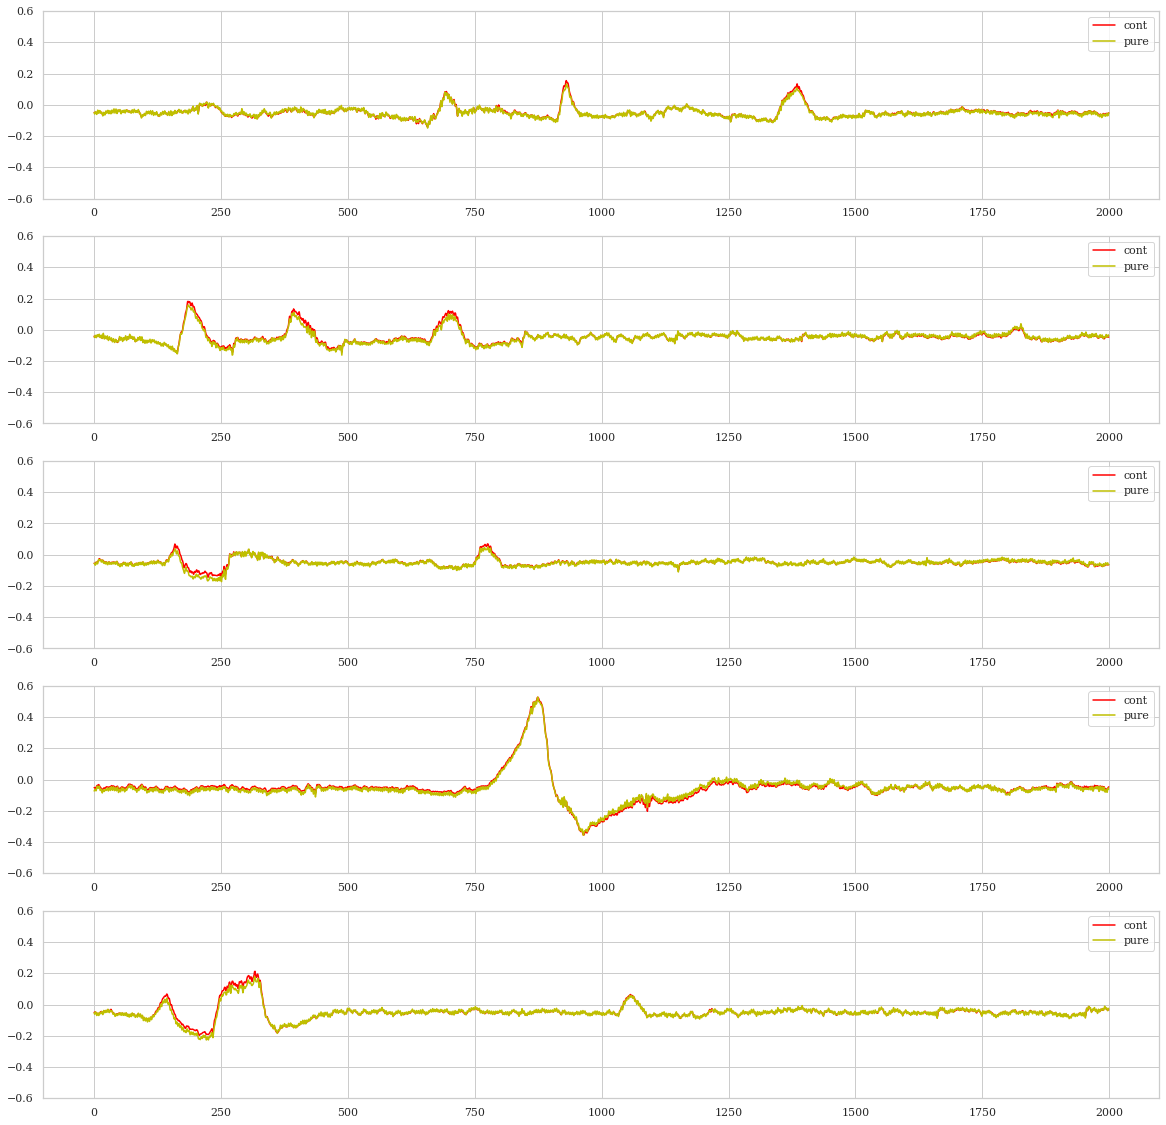

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = eval_cont_eeg[idx_segment, idx_ch, :]
        e_pure = eval_cleaned_eeg[idx_segment, idx_ch, :]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].legend(loc='upper right')
        axs[idx_row].set_ylim(-0.6,0.6)
        
print(e_cont.shape)
print(e_pure.shape)

plt.show()

In [ ]:
print(np.mean(train_cont_eeg))
print(np.max(train_cont_eeg))
print(np.min(train_cont_eeg))

print(np.mean(eval_cont_eeg))
print(np.max(eval_cont_eeg))
print(np.min(eval_cont_eeg))

print(np.mean(train_cleaned_eeg))
print(np.max(train_cleaned_eeg))
print(np.min(train_cleaned_eeg))

print(np.mean(eval_cleaned_eeg))
print(np.max(eval_cleaned_eeg))
print(np.min(eval_cleaned_eeg))

-0.08330916773519159
1.0
-1.0
-0.04926124410340763
1.0
-1.0
-0.002969173373465517
1.0
-1.0
-0.0515969830404037
1.0
-1.0


In [ ]:
def segmentation(in_signals, new_seg_duration, sfreq):

    n_epochs = in_signals.shape[0]
    out_data = []
    # Possible segments per epoch
    pos_segs = in_signals.shape[-1] // (new_seg_duration * sfreq)

    for idx_e_epoch in range(n_epochs):
        for idx_e_seg in range(pos_segs):
            start_index = int(idx_e_seg * sfreq)
            end_index = int(start_index + sfreq)

            # Select a segment
            e_segment = in_signals[idx_e_epoch, :, start_index:end_index]
            # Append
            out_data.append(e_segment)

    return np.array(out_data)

In [ ]:
# Segment each epoch into 1s segment
train_cont_1s_seg = segmentation(in_signals=train_cont_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)
eval_cont_1s_seg = segmentation(in_signals=eval_cont_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)
train_cleaned_1s_seg = segmentation(in_signals=train_cleaned_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)
eval_cleaned_1s_seg = segmentation(in_signals=eval_cleaned_eeg, new_seg_duration=1, sfreq=sfreq_after_epoch)

In [ ]:
print(train_cont_eeg.shape)
print(train_cont_1s_seg.shape)

(800, 30, 2000)
(8000, 30, 200)


In [ ]:
# print(np.all(train_cont_1s_seg[0,:,0:200] == train_cont_eeg[0,:,0:200]))
# print(np.all(train_cont_1s_seg[1,:,0:200] == train_cont_eeg[0,:,200:400]))
# print(np.all(train_cont_1s_seg[23,:,0:200] == train_cont_eeg[5,:,750:1000]))

In [ ]:
print(train_cont_1s_seg.shape)
print(eval_cont_1s_seg.shape)
print(train_cleaned_1s_seg.shape)
print(eval_cleaned_1s_seg.shape)

(8000, 30, 200)
(4000, 30, 200)
(8000, 30, 200)
(4000, 30, 200)


# Implemetation of **Dataset class** 
(for DataLoader)

In [ ]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, cont_eeg, clean_eeg):
        super(EEGDataset, self).__init__()
        self.cont_data = cont_eeg
        self.clean_data = clean_eeg

    def __getitem__(self, idx):
        cont_eeg = torch.tensor(self.cont_data[idx, :, :]).float()
        clean_eeg = torch.tensor(self.clean_data[idx, :, :]).float()
        return torch.unsqueeze(cont_eeg, 2), torch.unsqueeze(clean_eeg, 2)

    def __len__(self):
        return self.cont_data.shape[0]

## EEGANET

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
import math


class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=(1,3), stride=1, padding='same'),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=(1,3), stride=1, padding='same'),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=30, out_channels=30, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=(1,9), stride=1, padding='same'), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=(1,3), stride=1, padding='same'), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=(1,9), stride=1, padding='same'), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        # out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, input_len, n_eeg_chs = self.input_shape
        patch_h, patch_w = int(input_len / 2 ** 4), int(n_eeg_chs / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=(1, 3), stride=1, padding='same'))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=(1, 3), stride=2, padding=(0, 1)))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        # layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))
        self.model = nn.Sequential(*layers)
        self.after_discrim_block = nn.Sequential(
            nn.Linear(math.ceil(input_len / 16) * 512, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        x = self.model(img)
        x = x.flatten(start_dim=1)
        return self.after_discrim_block(x)
        # return self.model(img)

In [ ]:
epoch = 0
n_epochs = 200
# dataset_name = 
batch_size = 16
lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
n_cpu = 8
channels = train_cont_1s_seg.shape[1]
sample_len = train_cont_1s_seg.shape[-1]

omega = 5e-4

# Possibly unused!
sample_interval = 100
checkpoint_interval = 1
# hr_height = 
# hr_width = 

In [ ]:
cuda = torch.cuda.is_available()

# hr_shape = (hr_height, hr_width)

# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, sample_len, 1))
#feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
#feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
#criterion_content = torch.nn.L1Loss()
criterion_MSE = criterion_GAN

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    # feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    # criterion_content = criterion_content.cuda()

if epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# dataloader = DataLoader(
#     ImageDataset("../../data/%s" % dataset_name, hr_shape=hr_shape),
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=n_cpu,
# )

print(train_cont_1s_seg.shape)
print(eval_cont_1s_seg.shape)
print(train_cleaned_1s_seg.shape)
print(eval_cleaned_1s_seg.shape)

train_dataset = EEGDataset(cont_eeg=train_cont_1s_seg, clean_eeg=train_cleaned_1s_seg)

ld_cont_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=n_cpu
)


(8000, 30, 200)
(4000, 30, 200)
(8000, 30, 200)
(4000, 30, 200)


In [ ]:
# ----------
#  Training
# ----------

for epoch in range(epoch, n_epochs):
    for i, (cont_eeg, clean_eeg) in enumerate(ld_cont_train):

        # # Configure model input
        # imgs_lr = Variable(imgs["lr"].type(Tensor))
        # imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = torch.ones(cont_eeg.shape[0], 1, requires_grad=False)
        fake = torch.zeros(cont_eeg.shape[0], 1, requires_grad=False)
        if cuda:
          cont_eeg = cont_eeg.to("cuda")
          clean_eeg = clean_eeg.to("cuda")
          valid = valid.to("cuda")
          fake = fake.to("cuda")

        # ------------------
        #  Train Generators
        # ------------------
        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_clean_eeg = generator(cont_eeg)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_clean_eeg), valid)

        # Content loss
        # gen_features = feature_extractor(gen_hr)
        # real_features = feature_extractor(imgs_hr)
        # loss_content = criterion_content(gen_features, real_features.detach())
        loss_mse = criterion_MSE(gen_clean_eeg, clean_eeg)

        # Total loss
        #loss_G = loss_content + 1e-3 * loss_GAN
        loss_G = loss_mse + omega * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(clean_eeg), valid)
        loss_fake = criterion_GAN(discriminator(gen_clean_eeg.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(ld_cont_train), loss_D.item(), loss_G.item())
        )

        batches_done = epoch * len(ld_cont_train) + i
        # if batches_done % sample_interval == 0:
        #     # Save image grid with upsampled inputs and SRGAN outputs
        #     imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
        #     gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
        #     imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
        #     img_grid = torch.cat((imgs_lr, gen_hr), -1)
        #     save_image(img_grid, "images/%d.png" % batches_done, normalize=False)

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), f"saved_models_17_01/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), f"saved_models_17_01/discriminator_%d.pth" % epoch)

Streaming output truncated to the last 5000 lines.
[Epoch 190/200] [Batch 0/500] [D loss: 0.033635] [G loss: 0.000714]
[Epoch 190/200] [Batch 1/500] [D loss: 0.065670] [G loss: 0.000911]
[Epoch 190/200] [Batch 2/500] [D loss: 0.034567] [G loss: 0.000532]
[Epoch 190/200] [Batch 3/500] [D loss: 0.025678] [G loss: 0.001385]
[Epoch 190/200] [Batch 4/500] [D loss: 0.017087] [G loss: 0.000647]
[Epoch 190/200] [Batch 5/500] [D loss: 0.004550] [G loss: 0.001009]
[Epoch 190/200] [Batch 6/500] [D loss: 0.051570] [G loss: 0.000673]
[Epoch 190/200] [Batch 7/500] [D loss: 0.001719] [G loss: 0.000918]
[Epoch 190/200] [Batch 8/500] [D loss: 0.001363] [G loss: 0.000760]
[Epoch 190/200] [Batch 9/500] [D loss: 0.014779] [G loss: 0.000749]
[Epoch 190/200] [Batch 10/500] [D loss: 0.012330] [G loss: 0.000687]
[Epoch 190/200] [Batch 11/500] [D loss: 0.019165] [G loss: 0.001387]
[Epoch 190/200] [Batch 12/500] [D loss: 0.003717] [G loss: 0.000829]
[Epoch 190/200] [Batch 13/500] [D loss: 0.031319] [G loss: 0.0

## Evaluation

In [ ]:
selected_epoch = 199

# load model class
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, sample_len, 1))
# load model's parameters
generator.load_state_dict(torch.load(f"saved_models_17_01/generator_{selected_epoch}.pth"))
discriminator.load_state_dict(torch.load(f"saved_models_17_01/discriminator_{selected_epoch}.pth"))

# put model to selceted device
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

In [ ]:
print(type(generator))
print(type(discriminator))

<class '__main__.GeneratorResNet'>
<class '__main__.Discriminator'>


In [ ]:
# Denoise training
train_dataset = EEGDataset(cont_eeg=train_cont_1s_seg, clean_eeg=train_cleaned_1s_seg)

ld_cont_eval = DataLoader(
    train_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=n_cpu
)

# ----------
# Evaluating
# ----------
generator.eval()
discriminator.eval()

train_denoised_1s_eeg = []

with torch.no_grad():
    for i, (cont_eeg, clean_eeg) in enumerate(ld_cont_eval):
        if cuda:
            cont_eeg = cont_eeg.to("cuda")
            clean_eeg = clean_eeg.to("cuda")

        # Generate a high resolution image from low resolution input
        e_denoised_eeg = generator(cont_eeg)
        # GPU to CPU
        e_denoised_eeg = e_denoised_eeg.cpu().detach().numpy()
        # Change type
        e_denoised_eeg = np.float64(e_denoised_eeg)
        train_denoised_1s_eeg.append(e_denoised_eeg)
        # break
    train_denoised_1s_eeg = np.array(train_denoised_1s_eeg)

In [ ]:
print(train_cont_eeg.shape)
print(train_cont_1s_seg.shape)

(800, 30, 2000)
(8000, 30, 200)


In [ ]:
print(type(train_cont_1s_seg))
print(type(train_cleaned_1s_seg))
print(type(train_denoised_1s_eeg))

print(train_cont_1s_seg.shape)
print(train_cleaned_1s_seg.shape)
print(train_denoised_1s_eeg.shape)

# Reduce dimensions
train_denoised_1s_eeg = train_denoised_1s_eeg.squeeze(1).squeeze(-1)
print(train_denoised_1s_eeg.shape)

# Combine 4 of 1-s epochs to a 4s epoch
train_denoised_eeg = []
n_4s_seg = train_denoised_1s_eeg.shape[0]
skip_rate = int(train_cont_eeg.shape[-1] / train_cont_1s_seg.shape[-1])

for idx_e_seg in range(0,n_4s_seg,skip_rate):
    start_idx = idx_e_seg
    end_idx = start_idx + skip_rate
    list_1s_segs = train_denoised_1s_eeg[start_idx:end_idx, :, :]
    combined_segment = np.concatenate(list_1s_segs, axis=-1)
    train_denoised_eeg.append(combined_segment)

train_denoised_eeg = np.array(train_denoised_eeg)
print(train_denoised_eeg.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(8000, 30, 200)
(8000, 30, 200)
(8000, 1, 30, 200, 1)
(8000, 30, 200)
(800, 30, 2000)


In [ ]:
print(train_cont_eeg.shape)
print(train_cleaned_eeg.shape)
print(train_denoised_eeg.shape)

print(train_cont_eeg.dtype)
print(train_cleaned_eeg.dtype)
print(train_denoised_eeg.dtype)

print(train_cont_events.shape)

(800, 30, 2000)
(800, 30, 2000)
(800, 30, 2000)
float64
float64
float64
(800, 3)


(2000,)
(2000,)
(2000,)


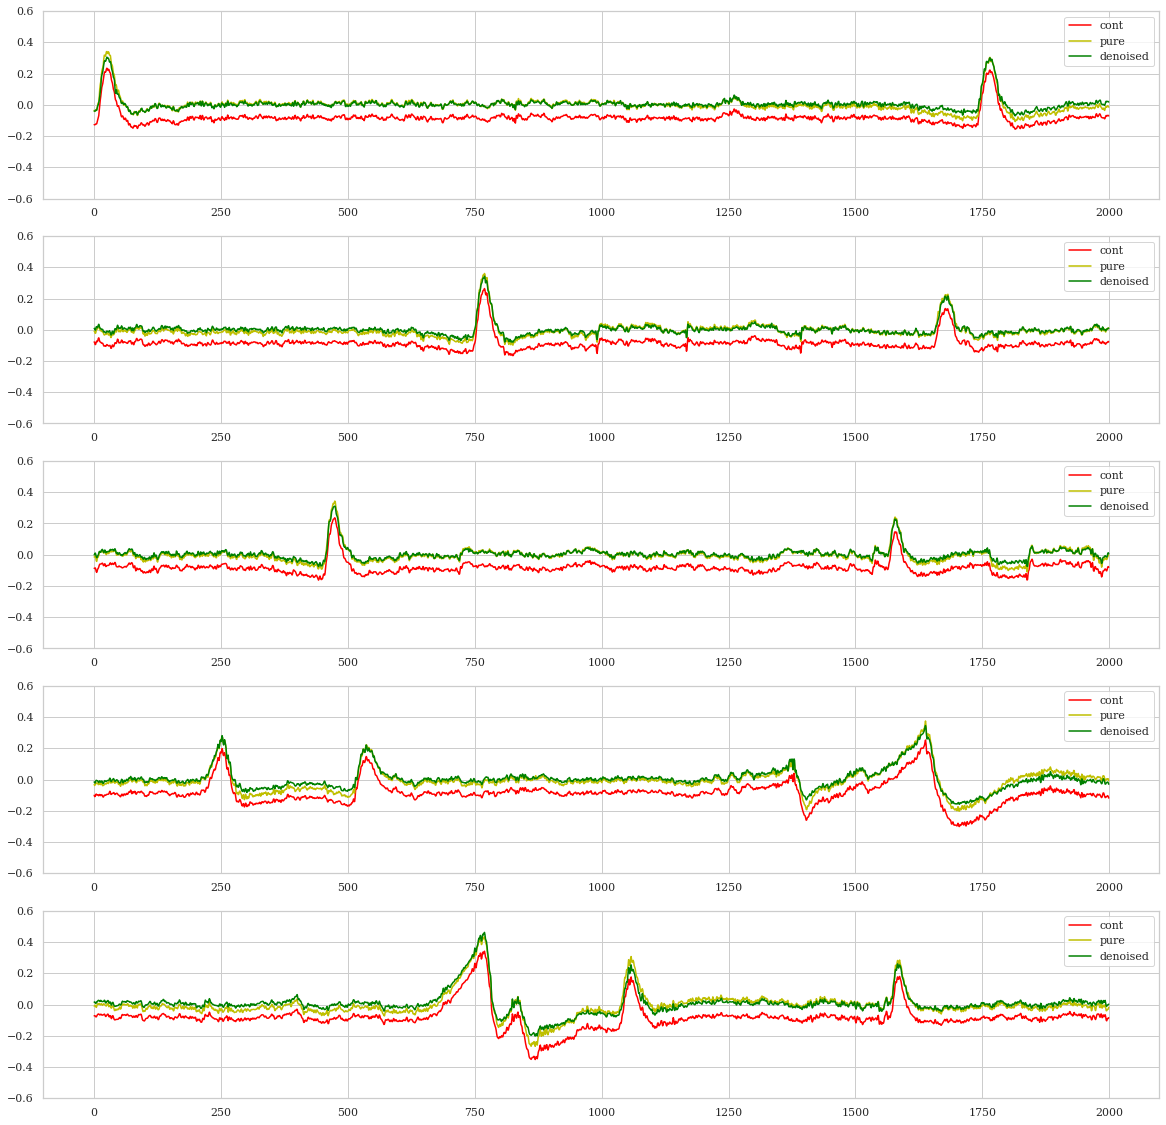

In [ ]:
n_rows = 5
n_cols = 1 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = train_cont_eeg[idx_segment, idx_ch, :]
        e_pure = train_cleaned_eeg[idx_segment, idx_ch, :]
        e_denoised = train_denoised_eeg[idx_segment, idx_ch,:]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].plot(e_denoised, 'g', label='denoised')
        axs[idx_row].legend(loc='upper right')
        axs[idx_row].set_ylim(-0.6,0.6)

print(e_cont.shape)
print(e_pure.shape)
print(e_denoised.shape)

plt.show()

In [ ]:
print(train_cont_eeg.shape)
print(train_cleaned_eeg.shape)
print(train_denoised_eeg.shape)

print(train_cont_eeg.dtype)
print(train_cleaned_eeg.dtype)
print(train_denoised_eeg.dtype)

print(train_cont_events.shape)

(800, 30, 2000)
(800, 30, 2000)
(800, 30, 2000)
float64
float64
float64
(800, 3)


#### Eval dateloader

In [ ]:
eval_dataset = EEGDataset(cont_eeg=eval_cont_1s_seg, clean_eeg=eval_cleaned_1s_seg)

ld_cont_eval = DataLoader(
    eval_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=n_cpu
)

# ----------
# Evaluating
# ----------
generator.eval()
discriminator.eval()

eval_denoised_1s_eeg = []

with torch.no_grad():
    for i, (cont_eeg, clean_eeg) in enumerate(ld_cont_eval):
        if cuda:
            cont_eeg = cont_eeg.to("cuda")
            clean_eeg = clean_eeg.to("cuda")

        # Generate a high resolution image from low resolution input
        e_denoised_eeg = generator(cont_eeg)
        # GPU to CPU
        e_denoised_eeg = e_denoised_eeg.cpu().detach().numpy()
        # Change type
        e_denoised_eeg = np.float64(e_denoised_eeg)
        eval_denoised_1s_eeg.append(e_denoised_eeg)
        # break
    eval_denoised_1s_eeg = np.array(eval_denoised_1s_eeg)

In [ ]:
print(type(eval_cont_1s_seg))
print(type(eval_cleaned_1s_seg))
print(type(eval_denoised_1s_eeg))

print(eval_cont_1s_seg.shape)
print(eval_cleaned_1s_seg.shape)
print(eval_denoised_1s_eeg.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4000, 30, 200)
(4000, 30, 200)
(4000, 1, 30, 200, 1)


In [ ]:
# Reduce dimensions
eval_denoised_1s_eeg = eval_denoised_1s_eeg.squeeze(1).squeeze(-1)
print(eval_denoised_1s_eeg.shape)

(4000, 30, 200)


(200,)
(200,)
(200,)


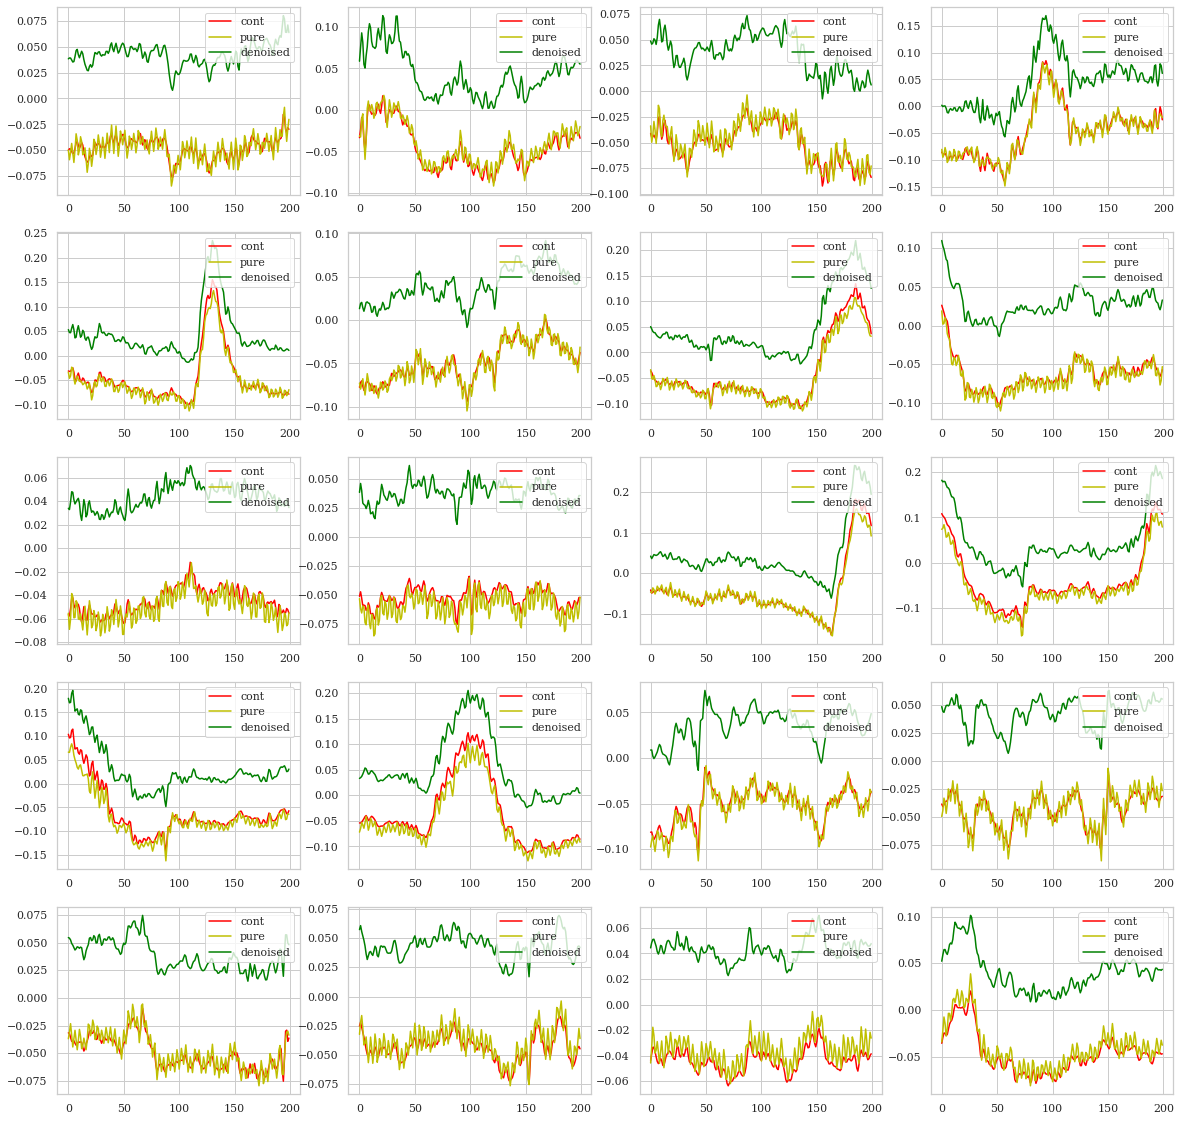

In [ ]:
n_rows = 5
n_cols = 4 # Imagery period = 4 (1 second * 4)
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = eval_cont_1s_seg[idx_segment, idx_ch, :]
        e_pure = eval_cleaned_1s_seg[idx_segment, idx_ch, :]
        e_denoised = eval_denoised_1s_eeg[idx_segment, idx_ch,:]

        idx_segment = idx_segment + 1 
        
        axs[idx_row, idx_col].plot(e_cont, 'r',label='cont')
        axs[idx_row, idx_col].plot(e_pure, 'y', label='pure')
        axs[idx_row, idx_col].plot(e_denoised, 'g', label='denoised')
        axs[idx_row, idx_col].legend(loc='upper right')

print(e_cont.shape)
print(e_pure.shape)
print(e_denoised.shape)

plt.show()

In [ ]:
# Combine 4 of 1-s epochs to a 4s epoch
eval_denoised_eeg = []
n_4s_seg = eval_denoised_1s_eeg.shape[0]
skip_rate = int(train_cont_eeg.shape[-1] / train_cont_1s_seg.shape[-1])

for idx_e_seg in range(0,n_4s_seg,skip_rate):
    start_idx = idx_e_seg
    end_idx = start_idx + skip_rate
    list_1s_segs = eval_denoised_1s_eeg[start_idx:end_idx, :, :]
    combined_segment = np.concatenate(list_1s_segs, axis=-1)
    eval_denoised_eeg.append(combined_segment)

eval_denoised_eeg = np.array(eval_denoised_eeg)
print(eval_denoised_eeg.shape)

(400, 30, 2000)


In [ ]:
print(eval_cont_eeg.shape)
print(eval_cleaned_eeg.shape)
print(eval_denoised_eeg.shape)

print(eval_cont_eeg.dtype)
print(eval_cleaned_eeg.dtype)
print(eval_denoised_eeg.dtype)

print(eval_cont_events.shape)

(400, 30, 2000)
(400, 30, 2000)
(400, 30, 2000)
float64
float64
float64
(400, 3)


(2000,)
(2000,)
(2000,)


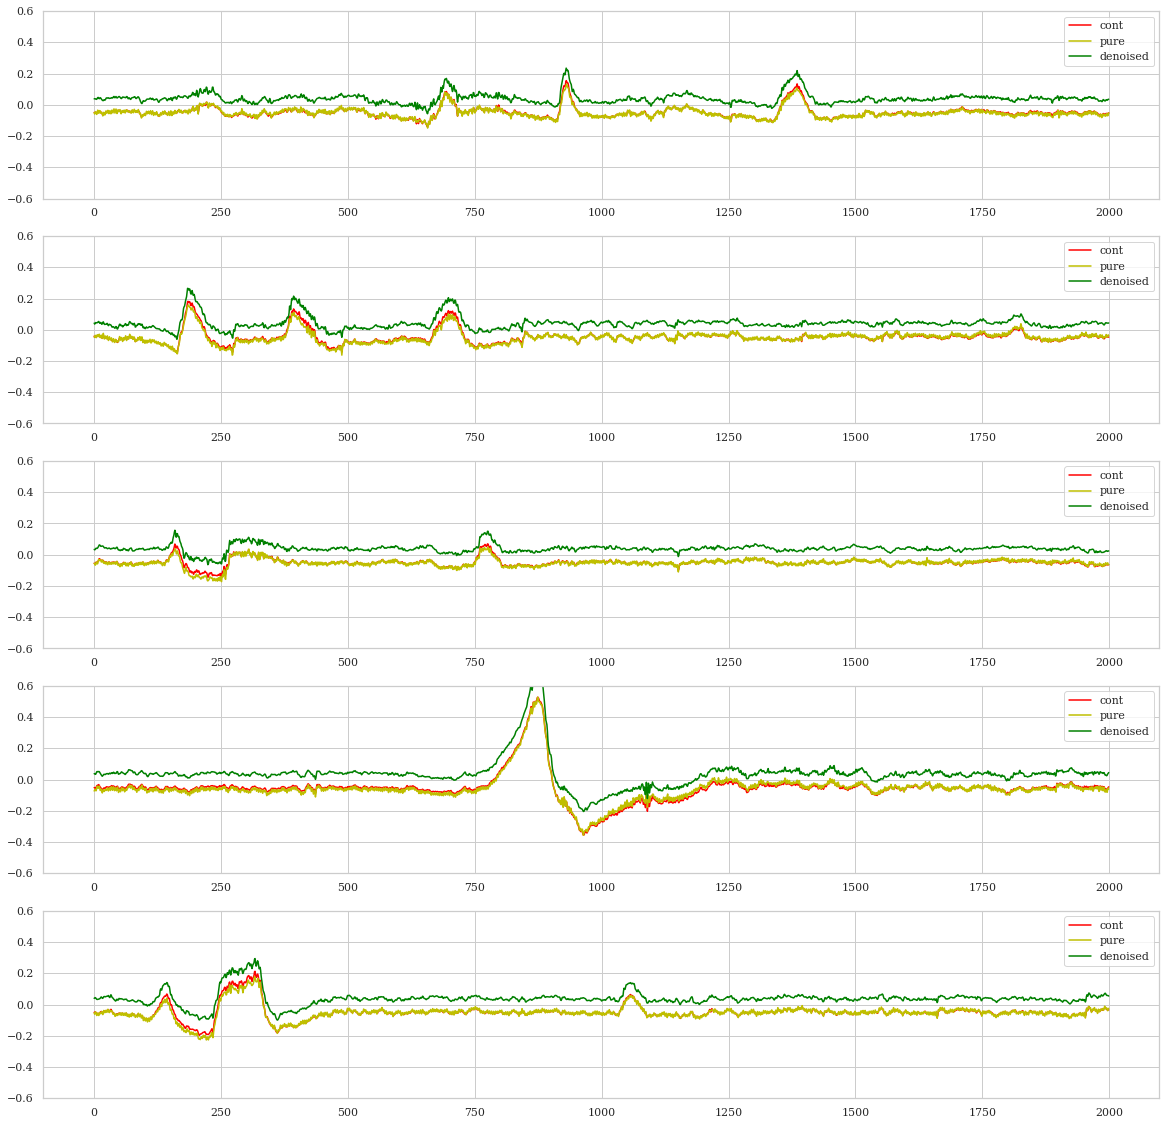

In [ ]:
n_rows = 5
n_cols = 1 # Task period
idx_ch = 0

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = eval_cont_eeg[idx_segment, idx_ch, :]
        e_pure = eval_cleaned_eeg[idx_segment, idx_ch, :]
        e_denoised = eval_denoised_eeg[idx_segment, idx_ch,:]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].plot(e_denoised, 'g', label='denoised')
        axs[idx_row].legend(loc='upper right')
        axs[idx_row].set_ylim(-0.6,0.6)

print(e_cont.shape)
print(e_pure.shape)
print(e_denoised.shape)

plt.show()

(2000,)
(2000,)
(2000,)


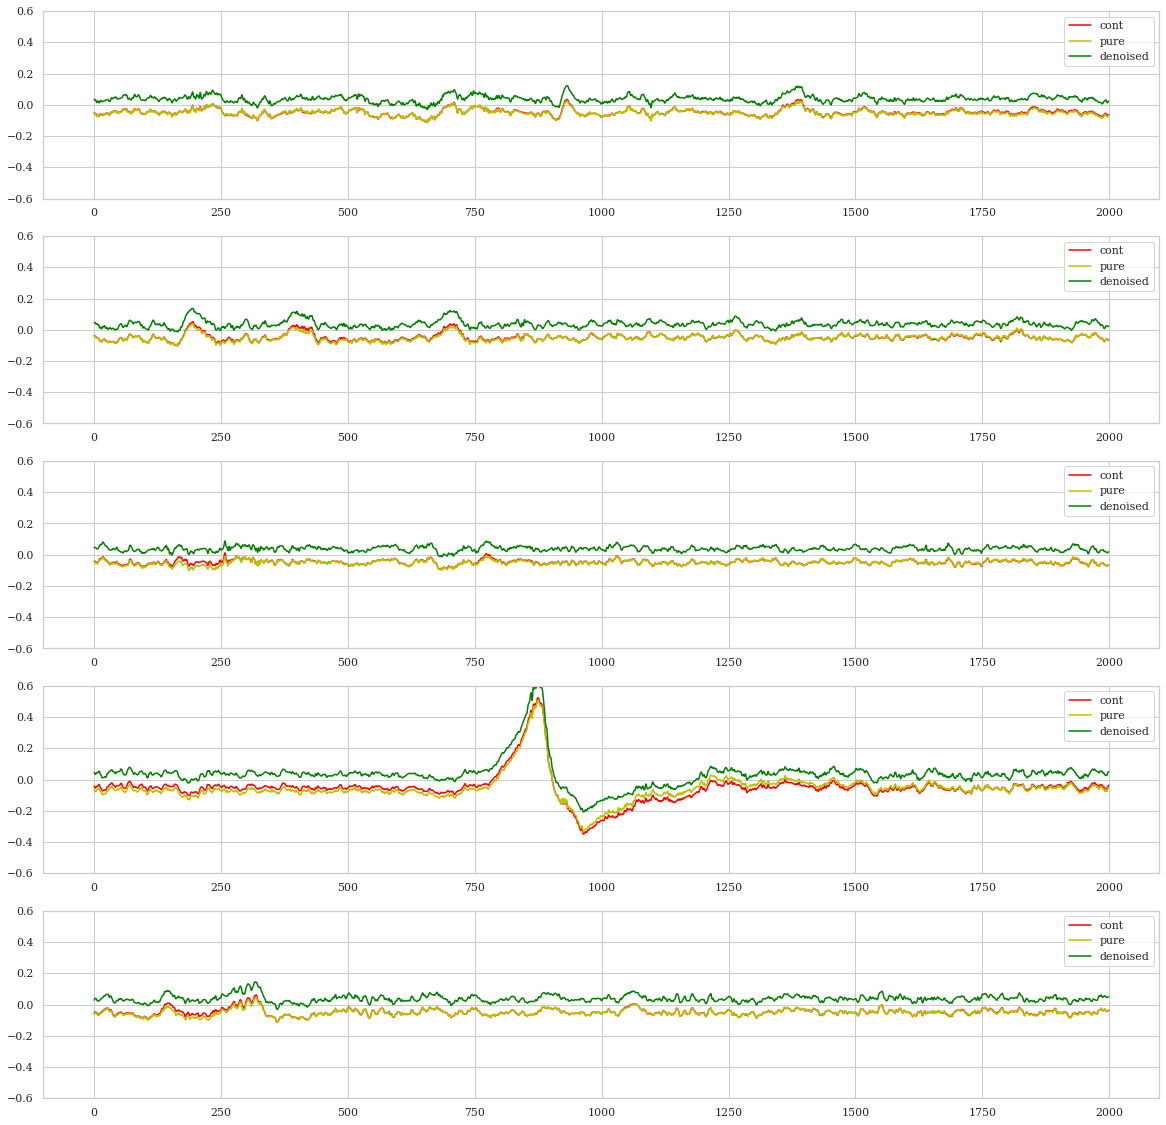

In [ ]:
n_rows = 5
n_cols = 1 # Task period
idx_ch = 10

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = eval_cont_eeg[idx_segment, idx_ch, :]
        e_pure = eval_cleaned_eeg[idx_segment, idx_ch, :]
        e_denoised = eval_denoised_eeg[idx_segment, idx_ch,:]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].plot(e_denoised, 'g', label='denoised')
        axs[idx_row].legend(loc='upper right')
        axs[idx_row].set_ylim(-0.6,0.6)

print(e_cont.shape)
print(e_pure.shape)
print(e_denoised.shape)

plt.show()

(2000,)
(2000,)
(2000,)


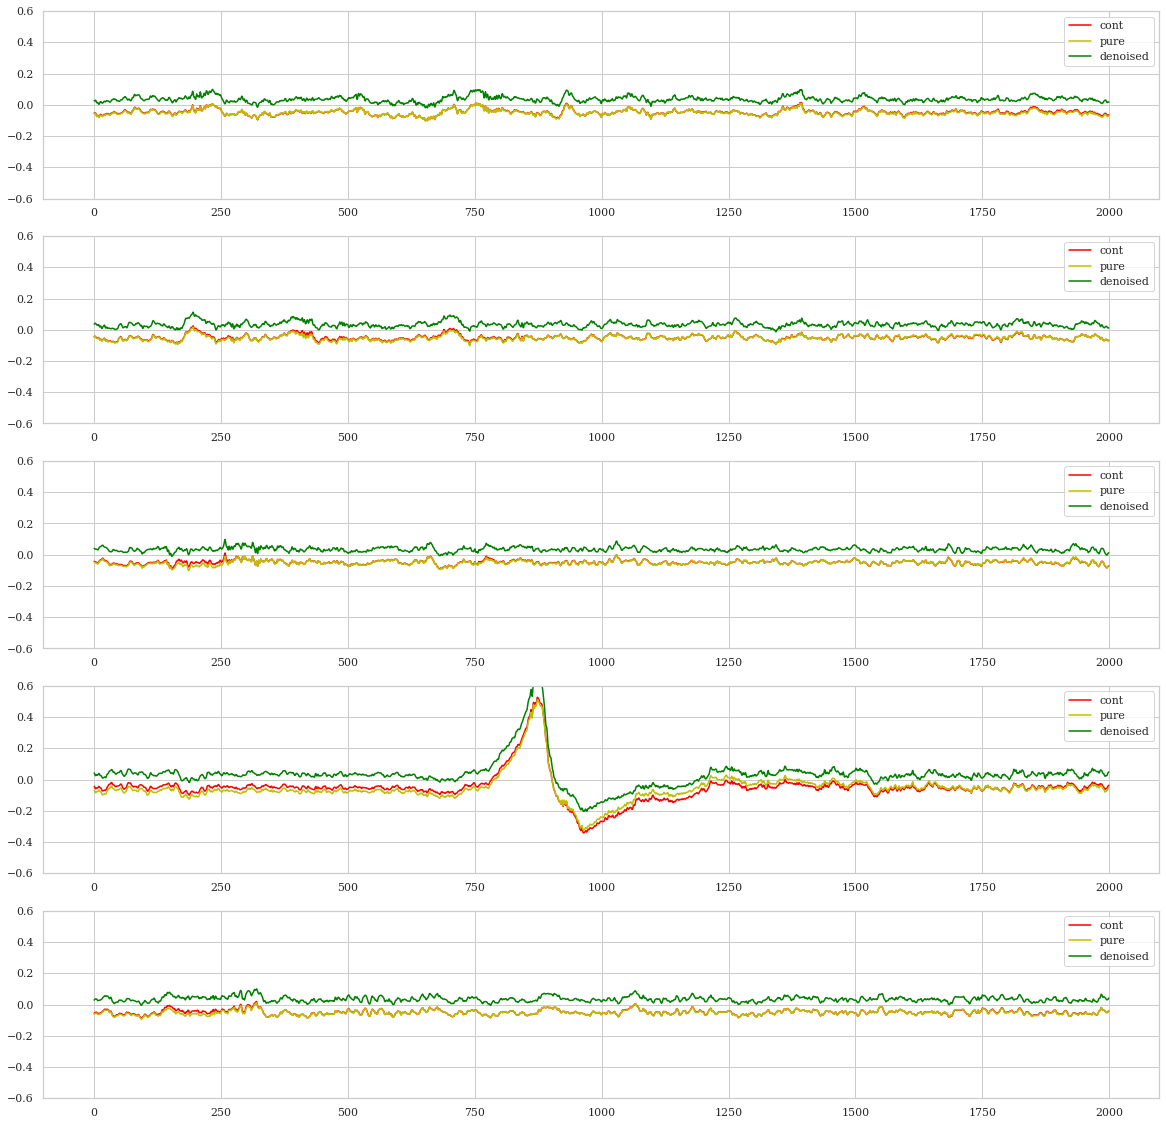

In [ ]:
n_rows = 5
n_cols = 1 # Task period
idx_ch = 11

fig, axs = plt.subplots(n_rows, n_cols,figsize=(20,20))

idx_segment = 0
for idx_row in range(n_rows):
    for idx_col in range(n_cols):

        e_cont = eval_cont_eeg[idx_segment, idx_ch, :]
        e_pure = eval_cleaned_eeg[idx_segment, idx_ch, :]
        e_denoised = eval_denoised_eeg[idx_segment, idx_ch,:]

        idx_segment = idx_segment + 1 
        
        axs[idx_row,].plot(e_cont, 'r',label='cont')
        axs[idx_row].plot(e_pure, 'y', label='pure')
        axs[idx_row].plot(e_denoised, 'g', label='denoised')
        axs[idx_row].legend(loc='upper right')
        axs[idx_row].set_ylim(-0.6,0.6)

print(e_cont.shape)
print(e_pure.shape)
print(e_denoised.shape)

plt.show()

In [ ]:
print(eval_cont_eeg.shape)
print(eval_cleaned_eeg.shape)
print(eval_denoised_eeg.shape)

print(eval_cont_eeg.dtype)
print(eval_cleaned_eeg.dtype)
print(eval_denoised_eeg.dtype)

print(eval_cont_events.shape)

(400, 30, 2000)
(400, 30, 2000)
(400, 30, 2000)
float64
float64
float64
(400, 3)


# Classification
- 01 = CSP + SVM/LCA
- 02 = EEGNet
    - Note of EEGNET's problems
        - FC Layer
            x = x.reshape(-1, 4*2*7)
        - Label must start with 0
    - Data format:
        Datatype - float32 (both X and Y) <br>
        X.shape - (#samples, 1, #timepoints,  #channels) <br>
        Y.shape - (#samples)

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class EEGNet(nn.Module):
    def __init__(self):
        # Modify self.T, self.fc1 
        super(EEGNet, self).__init__()
        self.T = 2000 # #samples per task
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 30), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(4*2*125, 1)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.reshape(-1, 4*2*125)
        x = torch.sigmoid(self.fc1(x))
        return x


net = EEGNet().cuda(0)
print(net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 2000, 30)).cuda(0))))
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

tensor([[0.2171]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 100
    
    predicted = []
    
    for i in range(int(len(X)/batch_size)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]).cuda(0))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X).cuda(0))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
    return results

In [ ]:
list_epochs_modeling = [train_cont_eeg,
                        train_cleaned_eeg,
                        train_denoised_eeg,
                        eval_cont_eeg,
                        eval_cleaned_eeg,
                        eval_denoised_eeg]

print(train_cont_events[:,-1].shape)
print(train_cont_events[:,-1][:10])
print(eval_cont_events[:,-1].shape)
print(eval_cont_events[:,-1][:10])

for e_type in list_epochs_modeling:
    # print(e_type.get_data().shape)
    print(e_type.shape)

(800,)
[1 2 1 2 1 2 1 2 2 1]
(400,)
[1 2 2 1 2 1 1 2 1 2]
(800, 30, 2000)
(800, 30, 2000)
(800, 30, 2000)
(400, 30, 2000)
(400, 30, 2000)
(400, 30, 2000)


In [ ]:
int(train_cont_eeg.shape[0] * 0.8)

640

In [ ]:
train_split = int(train_cont_eeg.shape[0] * 0.8)


X_train = train_denoised_eeg[:train_split,:,:]
y_train = train_cont_events[:train_split][:,-1]
X_val = train_denoised_eeg[train_split:,:,:]
y_val = train_cont_events[train_split:][:,-1]
X_test = eval_denoised_eeg
y_test = eval_cont_events[:,-1]

In [ ]:
train_denoised_eeg.shape

(800, 30, 2000)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

print(X_train.dtype)
print(y_train.dtype)
print(X_val.dtype)
print(y_val.dtype)
print(X_test.dtype)
print(y_test.dtype)

(640, 30, 2000)
(640,)
(160, 30, 2000)
(160,)
(400, 30, 2000)
(400,)
float64
int64
float64
int64
float64
int64


In [ ]:
def data_for_EEGNET(input_epochs):
    # X.shape - (#epochs, 1, #timepoints, #channels)
    output_epochs = []
    for e_epoch in input_epochs:
        e_epoch = e_epoch.transpose()
        e_epoch = np.expand_dims(e_epoch,axis=0)
        # print(e_epoch.shape)
        output_epochs.append(e_epoch)
        # break
    return np.array(output_epochs).astype('float32')

In [ ]:
X_train = data_for_EEGNET(X_train)
X_val = data_for_EEGNET(X_val)
X_test = data_for_EEGNET(X_test)

y_train = y_train - 1 # Start with 0
y_val = y_val - 1 # Start with 0
y_test = y_test - 1 # Start with 0

print(y_train[:10])
print(y_val[:10])
print(y_test[:10])

[0 1 0 1 0 1 0 1 1 0]
[0 1 1 0 0 1 0 1 0 1]
[0 1 1 0 1 0 0 1 0 1]


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

print(X_train.dtype)
print(y_train.dtype)
print(X_val.dtype)
print(y_val.dtype)
print(X_test.dtype)
print(y_test.dtype)

(640, 1, 2000, 30)
(640,)
(160, 1, 2000, 30)
(160,)
(400, 1, 2000, 30)
(400,)
float32
int64
float32
int64
float32
int64


#### Run

In [ ]:
batch_size = 10

list_training_loss = []
list_train_performance = []
list_valid_performance = []
list_test_performance = []

for epoch in range(10):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    for i in range(int((len(X_train)/batch_size-1))):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        optimizer.step()
        
        running_loss += loss.item()
        
    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]
    print(params)


    e_train_performance = evaluate(net, X_train, y_train, params)
    e_valid_performance = evaluate(net, X_train, y_train, params)
    e_test_performance = evaluate(net, X_train, y_train, params)

    print("Training Loss ", running_loss)
    print("Train - ", e_train_performance)
    print("Validation - ", e_valid_performance)
    print("Test - ", e_test_performance)

    list_training_loss.append(running_loss)
    list_train_performance.append(e_train_performance)
    list_valid_performance.append(e_valid_performance)
    list_test_performance.append(e_test_performance)


list_training_loss = np.array(list_training_loss)
list_train_performance = np.array(list_train_performance)
list_valid_performance = np.array(list_valid_performance)
list_test_performance = np.array(list_test_performance)


Epoch  0
['acc', 'auc', 'fmeasure']
Training Loss  47.63614499568939
Train -  [0.5671875, 0.598837890625, 0.5822021116138764]
Validation -  [0.5828125, 0.6263671875, 0.5997001499250375]
Test -  [0.590625, 0.619521484375, 0.622478386167147]

Epoch  1
['acc', 'auc', 'fmeasure']
Training Loss  41.72657334804535
Train -  [0.615625, 0.6902978515625, 0.6261398176291794]
Validation -  [0.6484375, 0.697216796875, 0.663677130044843]
Test -  [0.64375, 0.7013037109375, 0.6481481481481483]

Epoch  2
['acc', 'auc', 'fmeasure']
Training Loss  40.89526602625847
Train -  [0.671875, 0.7473339843749999, 0.6884272997032641]
Validation -  [0.6578125, 0.7360058593750001, 0.664624808575804]
Test -  [0.675, 0.739755859375, 0.688622754491018]

Epoch  3
['acc', 'auc', 'fmeasure']
Training Loss  37.39638730883598
Train -  [0.7078125, 0.7860351562500001, 0.6530612244897959]
Validation -  [0.7015625, 0.806015625, 0.6429906542056075]
Test -  [0.6921875, 0.7700878906249999, 0.6303939962476548]

Epoch  4
['acc', 'a

In [ ]:
best_acc = np.max(list_test_performance[:,0])
print(f"Best Accuracy = {best_acc}")

Best Accuracy = 0.83125


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [ ]:
list_epochs_modeling = [train_cont_eeg,
                        train_cleaned_eeg,
                        train_denoised_eeg,
                        eval_cont_eeg,
                        eval_cleaned_eeg,
                        eval_denoised_eeg]

for e_type in list_epochs_modeling:
    # print(e_type.get_data().shape)
    print(e_type.shape)


print(train_cont_events[:,-1].shape)
print(train_cont_events[:,-1][:10])
print(eval_cont_events[:,-1].shape)
print(eval_cont_events[:,-1][:10])

(800, 30, 2000)
(800, 30, 2000)
(800, 30, 2000)
(400, 30, 2000)
(400, 30, 2000)
(400, 30, 2000)
(800,)
[1 2 1 2 1 2 1 2 2 1]
(400,)
[1 2 2 1 2 1 1 2 1 2]


# Save data

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# train_cont_eeg
np.save(
    file=f'Datasets/Shin2017A/npy_files/train_eeg_None-None',
    arr=train_cont_eeg,
    allow_pickle=True, fix_imports=True)
# train_cleaned_eeg
np.save(
    file=f'Datasets/Shin2017A/npy_files/train_eeg_Regression-None',
    arr=train_cleaned_eeg,
    allow_pickle=True, fix_imports=True)
# train_denoised_eeg
np.save(
    file=f'Datasets/Shin2017A/npy_files/train_eeg_EEGANet-None',
    arr=train_denoised_eeg,
    allow_pickle=True, fix_imports=True)
# eval_cont_eeg
np.save(
    file=f'Datasets/Shin2017A/npy_files/eval_eeg_None-None',
    arr=eval_cont_eeg,
    allow_pickle=True, fix_imports=True)
# eval_cleaned_eeg
np.save(
    file=f'Datasets/Shin2017A/npy_files/eval_eeg_Regression-None',
    arr=eval_cleaned_eeg,
    allow_pickle=True, fix_imports=True)
# eval_denoised_eeg
np.save(
    file=f'Datasets/Shin2017A/npy_files/eval_eeg_EEGANet-None',
    arr=eval_denoised_eeg,
    allow_pickle=True, fix_imports=True)

# train_events
np.save(
    file=f'Datasets/Shin2017A/npy_files/train_events',
    arr=train_cont_events,
    allow_pickle=True, fix_imports=True)
# eval_events
np.save(
    file=f'Datasets/Shin2017A/npy_files/eval_events',
    arr=eval_cont_events,
    allow_pickle=True, fix_imports=True)